# 第七章 综合不同模型的组合学习

## 7.1 集成学习

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
#from scipy.misc import comb
from scipy.special import comb # n 选 k

In [3]:
def ensembleError(n_classifier, error):
    kStart = int(math.ceil(n_classifier / 2)) # 将参数的上线作为一个整数上限返回
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k) for k in range(kStart, n_classifier + 1)]
    return sum(probs)

In [4]:
ensembleError(n_classifier=11, error=.25)

0.03432750701904297

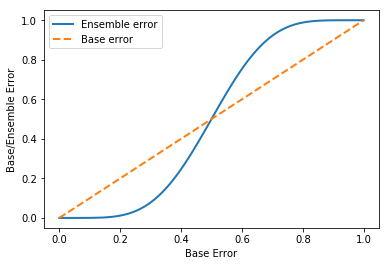

In [5]:
errorRange = np.arange(.0, 1.01, 0.01)
ensError = [ensembleError(n_classifier=11, error=error) for error in errorRange]
plt.plot(errorRange, ensError, label="Ensemble error", linewidth=2)
plt.plot(errorRange, errorRange, linestyle="--", label="Base error", linewidth=2)
plt.xlabel("Base Error")
plt.ylabel("Base/Ensemble Error")
plt.legend(loc="upper left")
plt.show()

In [6]:
np.argmax(np.bincount([0,0,1], weights=[.2, .2, .6]))

1

In [7]:
ex = np.array([[.9, .1], [.8, .2], [.4, .6]])
p = np.average(ex, axis=0, weights=[.2, .2, .6])
np.argmax(p)

0

In [8]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators

import operator


In [9]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """A majortity vote ensemble classifier
    """
    def __init__(self, classifiers, vote="classlabel", weights=None):
        """
        Parameters:
        -------------
        classifier : array-like, shape = [n_classifiers]
            Different classifiers for the ensemble

        vote : str, {"classlabel", "probability"}
            Default : "classlabel"
        weights : array-like,shape = [n_classifier]
        """
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """Fit classifiers
        
        Parameters
        -------------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features] Matrix of trainning samples
        y : {array-like}, shape = [n_samples] Vector of target class  labels
        
        Returns
        ---------
        self : object
        
        """        
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_ # ?
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """Predict class labels for X
        
        Parameters
        -------------
        X : {array-like, sparse matrix}, Shape = [n_samples, n_features] Matrix of trainning sample
        
        Returns
        --------
        maj_vote : array-like, shape = [n_sample]
            Predicted class labels
        """
        if self.vote == "probability":
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # "classlabel" vote
            # Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T # asarray 将输入转换为数组
            maj_vote = np.apply_along_axis(lambda x:np.argmax(
                np.bincount(x, weights=self.weights)),axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """Predict class probabilities for X.
        
        Parameters
        ------------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features] Training vertors, 
            where n_samples is the number of samples and n_features is the number of features.
        
        Returns
        ---------
        avg_proba : array-like, shape= [n_samples, n_classes] Weighted average probability for each class 
                            per sample
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """Get classifier parameter names for GridSearch."""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out["%s__%s" % (name, key)] = value
            return out

### 7.2.2 用多数票原则进行预测

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [11]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1, stratify=y)

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import numpy as np

In [13]:
clf1 = LogisticRegression(penalty="l2", C=.001, solver="saga", random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion="entropy", random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric="minkowski")
pipe1 = Pipeline([["sc", StandardScaler()], ["clf", clf1]])
pipe3 = Pipeline([["sc", StandardScaler()], ["clf", clf3]])
clf_labels = ["LogisticRegression", "Decision Tree", "KNN"]
print("10-fold cross validation:\n")
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring="roc_auc")
    print("ROC AUC: %.2f (+/- %.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [LogisticRegression]
ROC AUC: 0.89 (+/- 0.16) [Decision Tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


In [14]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ["Majority voting"] # clf_labels.append()
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring="roc_auc")
    print("Accuracu: %.2f (+/- %.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracu: 0.87 (+/- 0.17) [LogisticRegression]
Accuracu: 0.89 (+/- 0.16) [Decision Tree]
Accuracu: 0.88 (+/- 0.15) [KNN]
Accuracu: 0.94 (+/- 0.13) [Majority voting]


### 7.2.3 评估和优化集成分类器

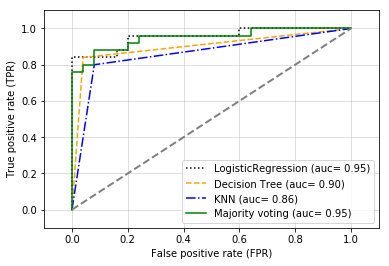

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', "orange", 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label="%s (auc= %.2f)" % (label, roc_auc))
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray', linewidth=2)
plt.xlim([-.1, 1.1])
plt.ylim([-.1, 1.1])
plt.grid(alpha=.5)
plt.xlabel("False positive rate (FPR)")
plt.ylabel("True positive rate (TPR)")
plt.show()

In [16]:
sc = StandardScaler()

In [17]:
xTrainStd = sc.fit_transform(X_train)

In [18]:
from itertools import product

##### product('ab', range(3)) --> ('a',0) ('a',1) ('a',2) ('b',0) ('b',1) ('b',2)
product((0,1), (0,1), (0,1)) --> (0,0,0) (0,0,1) (0,1,0) (0,1,1) (1,0,0) ...
product([0, 1], [0, 1]) (0, 0) (0, 1) (1, 0) (1, 1)

In [19]:
xMin = xTrainStd[:, 0].min() - 1
xMax = xTrainStd[:, 0].max() + 1

yMin = xTrainStd[:, 1].min() - 1
yMax = xTrainStd[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(xMin, xMax, .1), np.arange(yMin, yMax, .1)) 

In [20]:
mm, nn = np.meshgrid(np.arange(1, 5, 1), np.arange(6, 10, 1)) 

In [21]:
mm, nn # 注意复制轴的方向

(array([[1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4]]), array([[6, 6, 6, 6],
        [7, 7, 7, 7],
        [8, 8, 8, 8],
        [9, 9, 9, 9]]))

In [22]:
mm.ravel(), nn.ravel(),np.c_[mm.ravel(), nn.ravel()]

(array([1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]),
 array([6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9]),
 array([[1, 6],
        [2, 6],
        [3, 6],
        [4, 6],
        [1, 7],
        [2, 7],
        [3, 7],
        [4, 7],
        [1, 8],
        [2, 8],
        [3, 8],
        [4, 8],
        [1, 9],
        [2, 9],
        [3, 9],
        [4, 9]]))

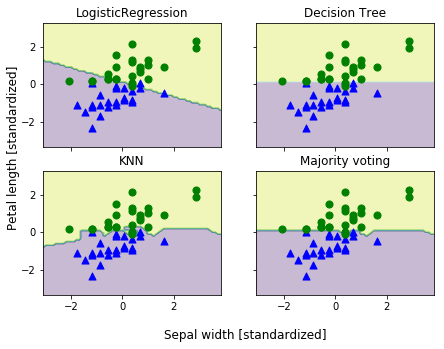

In [23]:
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(xTrainStd, y_train)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, z, alpha=.3)
    axarr[idx[0], idx[1]].scatter(xTrainStd[y_train==0, 0], xTrainStd[y_train==0, 1], c="blue", marker="^", s=50)
    axarr[idx[0], idx[1]].scatter(xTrainStd[y_train==1, 0], xTrainStd[y_train==1, 1], c="green", marker="o", s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -5.5, s="Sepal width [standardized]", ha="center", va="center", fontsize=12)
plt.text(-12.5, 4.5, s="Petal length [standardized]", ha="center", va="center", fontsize=12, rotation=90)
plt.show()

In [24]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=1, solver='saga',
           tol=0.0001, verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=Non

In [25]:
from sklearn.model_selection import GridSearchCV
params = {"decisiontreeclassifier__max_depth": [1, 2], "pipeline-1__clf__C": [.001, .1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params,cv=10,scoring='roc_auc')
grid.fit(X_train, y_train)

D:\ssoftware\anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\ssoftware\anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\ssoftware\anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\ssoftware\anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\ssoftware\anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2'...',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [26]:
for params, mean_score, scores in grid.grid_scores_: # 报错，没有这个属性
    print("%s.3f +/-%.2f %r" % (mean_score, score.std() / 2, params))

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

### 应用套装技术对葡萄酒数据集中的样本分类

In [40]:
import pandas as pd
import os

os.chdir(r"D:\360MoveData\Users\86138\Desktop\myself\刷过的书\python_机器学习")

dfWine = pd.read_csv("wine_data.csv", header=None)
dfWine.columns = ["Class label", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols",\
                 "Flavanoids", "Nonflavanoid Phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines",\
                 "Proline"]
dfWine = dfWine[dfWine["Class label"] != 1]
y = dfWine["Class label"].values
x = dfWine[["Alcohol", "OD280/OD315 of diluted wines"]].values

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=.2, random_state=1, stratify=y)

In [47]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth=None)
bag = BaggingClassifier(base_estimator=tree, # default decision tree
                        n_estimators=500,  #  the numbers of base_estimator
                        max_samples=1.,  #  从x中抽到训练集的样本数目/每个基本分类器
                        max_features=1.0, # 从x中抽到训练集的特征数目/每个基本分类器
                        bootstrap=True, #样本是否放回
                        bootstrap_features=False,  # 特征是否放回
                        n_jobs=1, 
                        random_state=1)


##### 单一修建决策树的模型泛化能力

In [48]:
from sklearn.metrics import accuracy_score
tree = tree.fit(xTrain, yTrain)
yTrainPred = tree.predict(xTrain)
yTestPred = tree.predict(xTest)
treeTrain = accuracy_score(yTrain, yTrainPred)
treeTest = accuracy_score(yTest, yTestPred)
print("Decision tree train/test accuracies %.3f/%.3f" % (treeTrain, treeTest))

Decision tree train/test accuracies 1.000/0.833


##### 套装分类器的模型泛化能力

In [51]:
bag = bag.fit(xTrain, yTrain)
yTrainPred = bag.predict(xTrain)
yTestPred = bag.predict(xTest)
bagTrain = accuracy_score(yTrain, yTrainPred)
bagTest = accuracy_score(yTest, yTestPred)
print("Bagging train/test accuracies %.3f/%.3f" % (bagTrain, bagTest))

Bagging train/test accuracies 1.000/0.917


##### 决策树和袋装分类器的在决策区域的差别

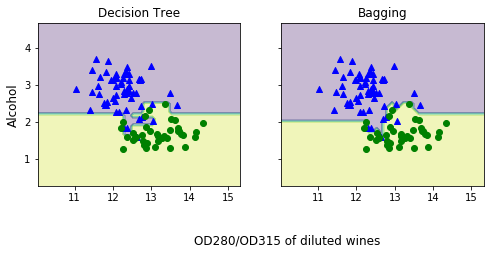

In [59]:
xMin = xTrain[:, 0].min() - 1
xMax = xTrain[:, 0].max() + 1
yMin = xTrain[:, 1].min() - 1
yMax = xTrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(xMin, xMax, .1), np.arange(yMin,yMax, .1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex="col", sharey="row", figsize=(8,3))
for idx, clf, tt in zip([0, 1], [tree, bag], ["Decision Tree", "Bagging"]):
    clf.fit(xTrain, yTrain)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, z, alpha=.3)
    axarr[idx].scatter(xTrain[yTrain==0, 0], xTrain[yTrain==0, 1], c="blue", marker="^")
    axarr[idx].scatter(xTrain[yTrain==1, 0], xTrain[yTrain==1, 1], c="green", marker="o")
    axarr[idx].set_title(tt)
axarr[0].set_ylabel("Alcohol", fontsize=12)
plt.text(10.2, -1.2, s="OD280/OD315 of diluted wines", ha="center", va="center", fontsize=12)
plt.show()

In [58]:
xx.shape

(45, 54)

### 用sklearn实现AdaBoost

In [61]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=.1, random_state=1)

tree = tree.fit(xTrain, yTrain)
yTrainPred = tree.predict(xTrain)
yTestPred = tree.predict(xTest)
treeTrain = accuracy_score(yTrain, yTrainPred)
treeTest = accuracy_score(yTest, yTestPred)
print("Decision tree train/test accuracies %.3f/%.3f" % (treeTrain, treeTest))

ada = ada.fit(xTrain, yTrain)
yTrainPred = ada.predict(xTrain)
yTestPred = ada.predict(xTest)
adaTrain = accuracy_score(yTrain, yTrainPred)
adaTest = accuracy_score(yTest, yTestPred)
print("AdaBoost train/test accuracies %.3f/%.3f" % (adaTrain, adaTest))


Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


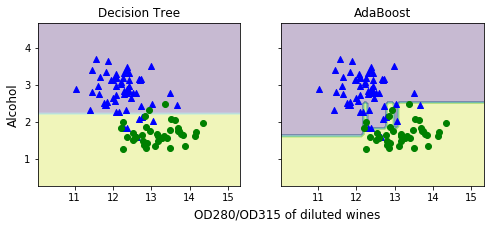

In [62]:
xMin = xTrain[:, 0].min() - 1
xMax = xTrain[:, 0].max() + 1
yMin = xTrain[:, 1].min() - 1
yMax = xTrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(xMin, xMax, .1), np.arange(yMin,yMax, .1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex="col", sharey="row", figsize=(8,3))
for idx, clf, tt in zip([0, 1], [tree, ada], ["Decision Tree", "AdaBoost"]):
    clf.fit(xTrain, yTrain)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, z, alpha=.3)
    axarr[idx].scatter(xTrain[yTrain==0, 0], xTrain[yTrain==0, 1], c="blue", marker="^")
    axarr[idx].scatter(xTrain[yTrain==1, 0], xTrain[yTrain==1, 1], c="green", marker="o")
    axarr[idx].set_title(tt)
axarr[0].set_ylabel("Alcohol", fontsize=12)
plt.text(10.2, -.5, s="OD280/OD315 of diluted wines", ha="center", va="center", fontsize=12)
plt.show()